In [15]:
import os
work_dir = "/content/TensorFlow-Tutorials/"
if os.getcwd() != work_dir:
    !git clone https://github.com/Hvass-Labs/TensorFlow-Tutorials.git
os.chdir(work_dir)

Cloning into 'TensorFlow-Tutorials'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 459 (delta 2), reused 6 (delta 2), pack-reused 450
Receiving objects: 100% (459/459), 62.79 MiB | 28.56 MiB/s, done.
Resolving deltas: 100% (212/212), done.


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from mnist import MNIST
from sklearn.metrics import confusion_matrix
import math

In [0]:
filter_size1 = 5
n_filters1 = 16
filter_size2 = 5
n_filters2 = 36
fc_size = 128

In [0]:
from mnist import MNIST
data = MNIST(data_dir = "data/MNIST")

In [0]:
img_size = data.img_size
img_size_flat = data.img_size_flat
img_shape = data.img_shape
num_classes = data.num_classes
num_channels = data.num_channels

In [20]:
print("Size of: ")
print("- Training Set: {0} \t\t".format(data.num_train))
print("- Test Set: {0} \t\t".format(data.num_test))
print("- Validation Set: {0} \t".format(data.num_val))

Size of: 
- Training Set: 55000 		
- Test Set: 10000 		
- Validation Set: 5000 	


In [0]:
def plot_images(images, cls_true, cls_pred = None):
    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap = 'binary')
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Predicted: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)    
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()    

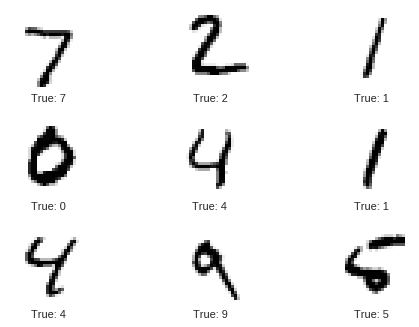

In [26]:
images = data.x_test[0:9]
cls_true = data.y_test_cls[0:9]
plot_images(images, cls_true)

In [0]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev = 0.05))

In [0]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [0]:
def new_convlayer(input, num_input_channels, filter_size, num_filters, use_pooling = True):
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape = shape)
    biases = new_biases(num_filters)
    layer = tf.nn.conv2d(input, filter = weights, strides = [1, 1, 1, 1], padding = 'SAME')
    layer += biases
    if use_pooling == True:
        layer = tf.nn.max_pool(value = layer, ksize = [1, 2, 2, 1], strides = [1, 1, 1, 1], padding = 'SAME')
    layer = tf.nn.relu(layer)    
    return layer, weights

In [0]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

In [0]:
def new_fc_layer(input, num_inputs, num_outputs, use_relu = True, drop_out = True):
    shape = [num_inputs, num_outputs]
    weights = new_weights(shape = shape)
    biases = new_biases(length = num_outputs)
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)
    if drop_out:
        layer = tf.nn.dropout(layer, keep_prob)   
    return layer    

In [0]:
x = tf.placeholder(tf.float32, shape = [None, img_size_flat], name = 'x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
keep_prob = tf.placeholder(tf.float32, shape = (), name = 'keep_prob')
y_true = tf.placeholder(tf.float32, shape = [None, num_classes], name = 'y_true')
y_true_cls = tf.argmax(y_true, axis = 1)

In [0]:
layer_conv1, weights_conv1 = new_convlayer(input = x_image, num_input_channels = num_channels, filter_size = filter_size1, num_filters = n_filters1, use_pooling = True)

In [0]:
layer_conv2, weights_conv2 = new_convlayer(input = layer_conv1, num_input_channels = n_filters1, filter_size = filter_size2, num_filters = n_filters2, use_pooling = True)

In [0]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [0]:
layer_fc1 = new_fc_layer(input = layer_flat, num_inputs = num_features, num_outputs = fc_size, use_relu = True)

In [0]:
layer_fc2 = new_fc_layer(input = layer_fc1, num_inputs = fc_size, num_outputs = num_classes, use_relu = False, drop_out = True)

In [0]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis = 1)

In [0]:
entropy = tf.nn.softmax_cross_entropy_with_logits(logits = layer_fc2, labels = y_true)
cost = tf.reduce_mean(entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = 0.0001).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
train_batch_size = 64
total_iterations = 0
def optimize(num_iterations):
    global total_iterations
    for i in range(total_iterations, total_iterations + num_iterations):
        x_batch, y_true_batch, _ = data.random_batch(batch_size = train_batch_size)
        feed_dict_train = {x: x_batch, y_true: y_true_batch, keep_prob: 0.9}
        sess.run(optimizer, feed_dict = feed_dict_train)
        if i%100 == 0:
            acc = sess.run(accuracy, feed_dict = feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i+1, acc))
    total_iterations += num_iterations        

In [0]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    image = data.x_test[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.y_test_cls[incorrect]
    return plot_images(images = image[0:9], cls_true = cls_true[0:9], cls_pred = cls_pred[0:9])

In [0]:
def print_confusion_matrix(cls_pred):
    cls_true = data.y_test_cls
    cm = confusion_matrix(y_true = cls_true, y_pred = cls_pred)
    print(cm)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.set_xticks(range(num_classes))
    plt.set_yticks(range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [0]:
#Helper Function for showing the performance
test_batch_size = 256
def print_test_accuracy():
    num_test = data.num_test
    cls_pred = np.zeros(shape = num_test, dtype = np.int)
    i = 0
    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = data.x_test[i:j,:]
        labels = data.y_test[i:j,:]
        feed_dict = {x: images, y_true: labels, keep_prob: 1}
        cls_pred[i:j] = sess.run(y_pred_cls, feed_dict = feed_dict)
        i = j
    cls_true = data.y_test_cls
    correct = (cls_pred == cls_true)
    correct_sum = correct.sum()
    accuracy = float(correct_sum)/num_test
    msg = "Accuracy on test set: {0:.1%}({1}/{2})"
    print(msg.format(accuracy, correct_sum, num_test))

In [165]:
print_test_accuracy()

Accuracy on test set: 10.1%(1013/10000)


In [166]:
optimize(num_iterations = 1)
print_test_accuracy()

Optimization Iteration:      1, Training Accuracy:  12.5%
Accuracy on test set: 10.9%(1093/10000)


In [167]:
optimize(num_iterations = 99)
print_test_accuracy()

Accuracy on test set: 84.3%(8429/10000)


In [168]:
optimize(num_iterations = 900)
print_test_accuracy()

Optimization Iteration:    101, Training Accuracy:  76.6%
Optimization Iteration:    201, Training Accuracy:  68.8%
Optimization Iteration:    301, Training Accuracy:  82.8%
Optimization Iteration:    401, Training Accuracy:  85.9%
Optimization Iteration:    501, Training Accuracy:  90.6%
Optimization Iteration:    601, Training Accuracy:  89.1%
Optimization Iteration:    701, Training Accuracy:  93.8%
Optimization Iteration:    801, Training Accuracy:  87.5%
Optimization Iteration:    901, Training Accuracy:  90.6%
Accuracy on test set: 96.0%(9602/10000)


In [169]:
optimize(num_iterations = 9000)
print_test_accuracy()

Optimization Iteration:   1001, Training Accuracy:  92.2%
Optimization Iteration:   1101, Training Accuracy:  93.8%
Optimization Iteration:   1201, Training Accuracy:  87.5%
Optimization Iteration:   1301, Training Accuracy:  96.9%
Optimization Iteration:   1401, Training Accuracy:  92.2%
Optimization Iteration:   1501, Training Accuracy:  87.5%
Optimization Iteration:   1601, Training Accuracy:  95.3%
Optimization Iteration:   1701, Training Accuracy:  93.8%
Optimization Iteration:   1801, Training Accuracy:  92.2%
Optimization Iteration:   1901, Training Accuracy:  95.3%
Optimization Iteration:   2001, Training Accuracy:  98.4%
Optimization Iteration:   2101, Training Accuracy:  96.9%
Optimization Iteration:   2201, Training Accuracy:  93.8%
Optimization Iteration:   2301, Training Accuracy:  96.9%
Optimization Iteration:   2401, Training Accuracy:  90.6%
Optimization Iteration:   2501, Training Accuracy:  92.2%
Optimization Iteration:   2601, Training Accuracy:  98.4%
Optimization I